In [13]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import unsupervised_scripts
import helper_scripts


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image
from tkinter import*
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

save_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/output/'+sample_name+'/'
if os.path.exists(save_dir) == False:
  os.mkdir(save_dir)

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
#image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=0)


In [14]:
image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=15)
save_input = helper_scripts.save_input()

(array([ 7050., 29250., 38260., 33220., 10900.,  7170.,  2640.,   300.,
          960.,   250.]),
 array([0.        , 0.1490053 , 0.2980106 , 0.4470159 , 0.5960212 ,
        0.7450265 , 0.8940318 , 1.0430371 , 1.1920424 , 1.34104769,
        1.49005299]),
 <BarContainer object of 10 artists>)

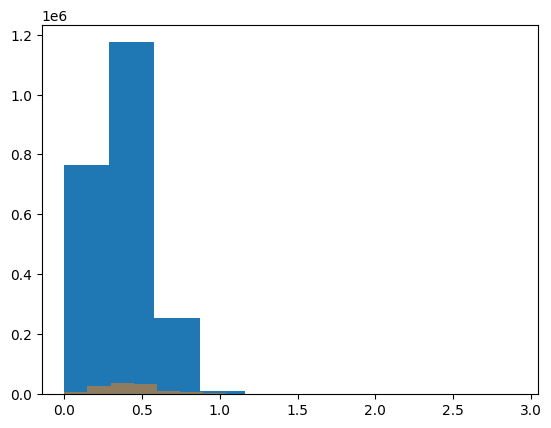

In [15]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0])
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5)

In [4]:
## Save Normalized Image and channels (ONLY FOR 2700-3100)

norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
norm_image = np.moveaxis(norm_image, 2, 0)
io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[-13:-10],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[-22:-19],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[-28:-25],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[-33:-30],axis=0).astype('float32'))

Text(0, 0.5, 'Normalized Intensity (A.U.)')

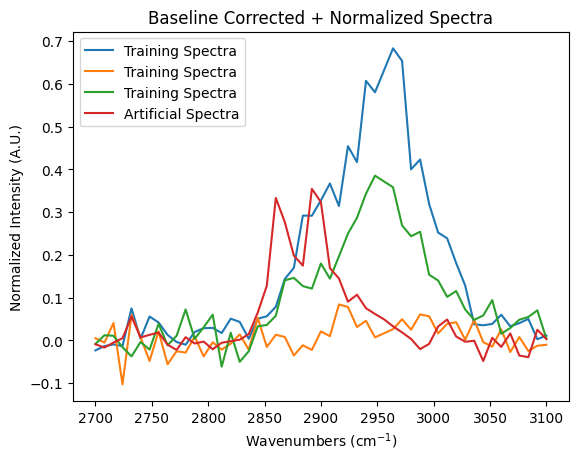

In [9]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [16]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

Accuracy Score: 1.0


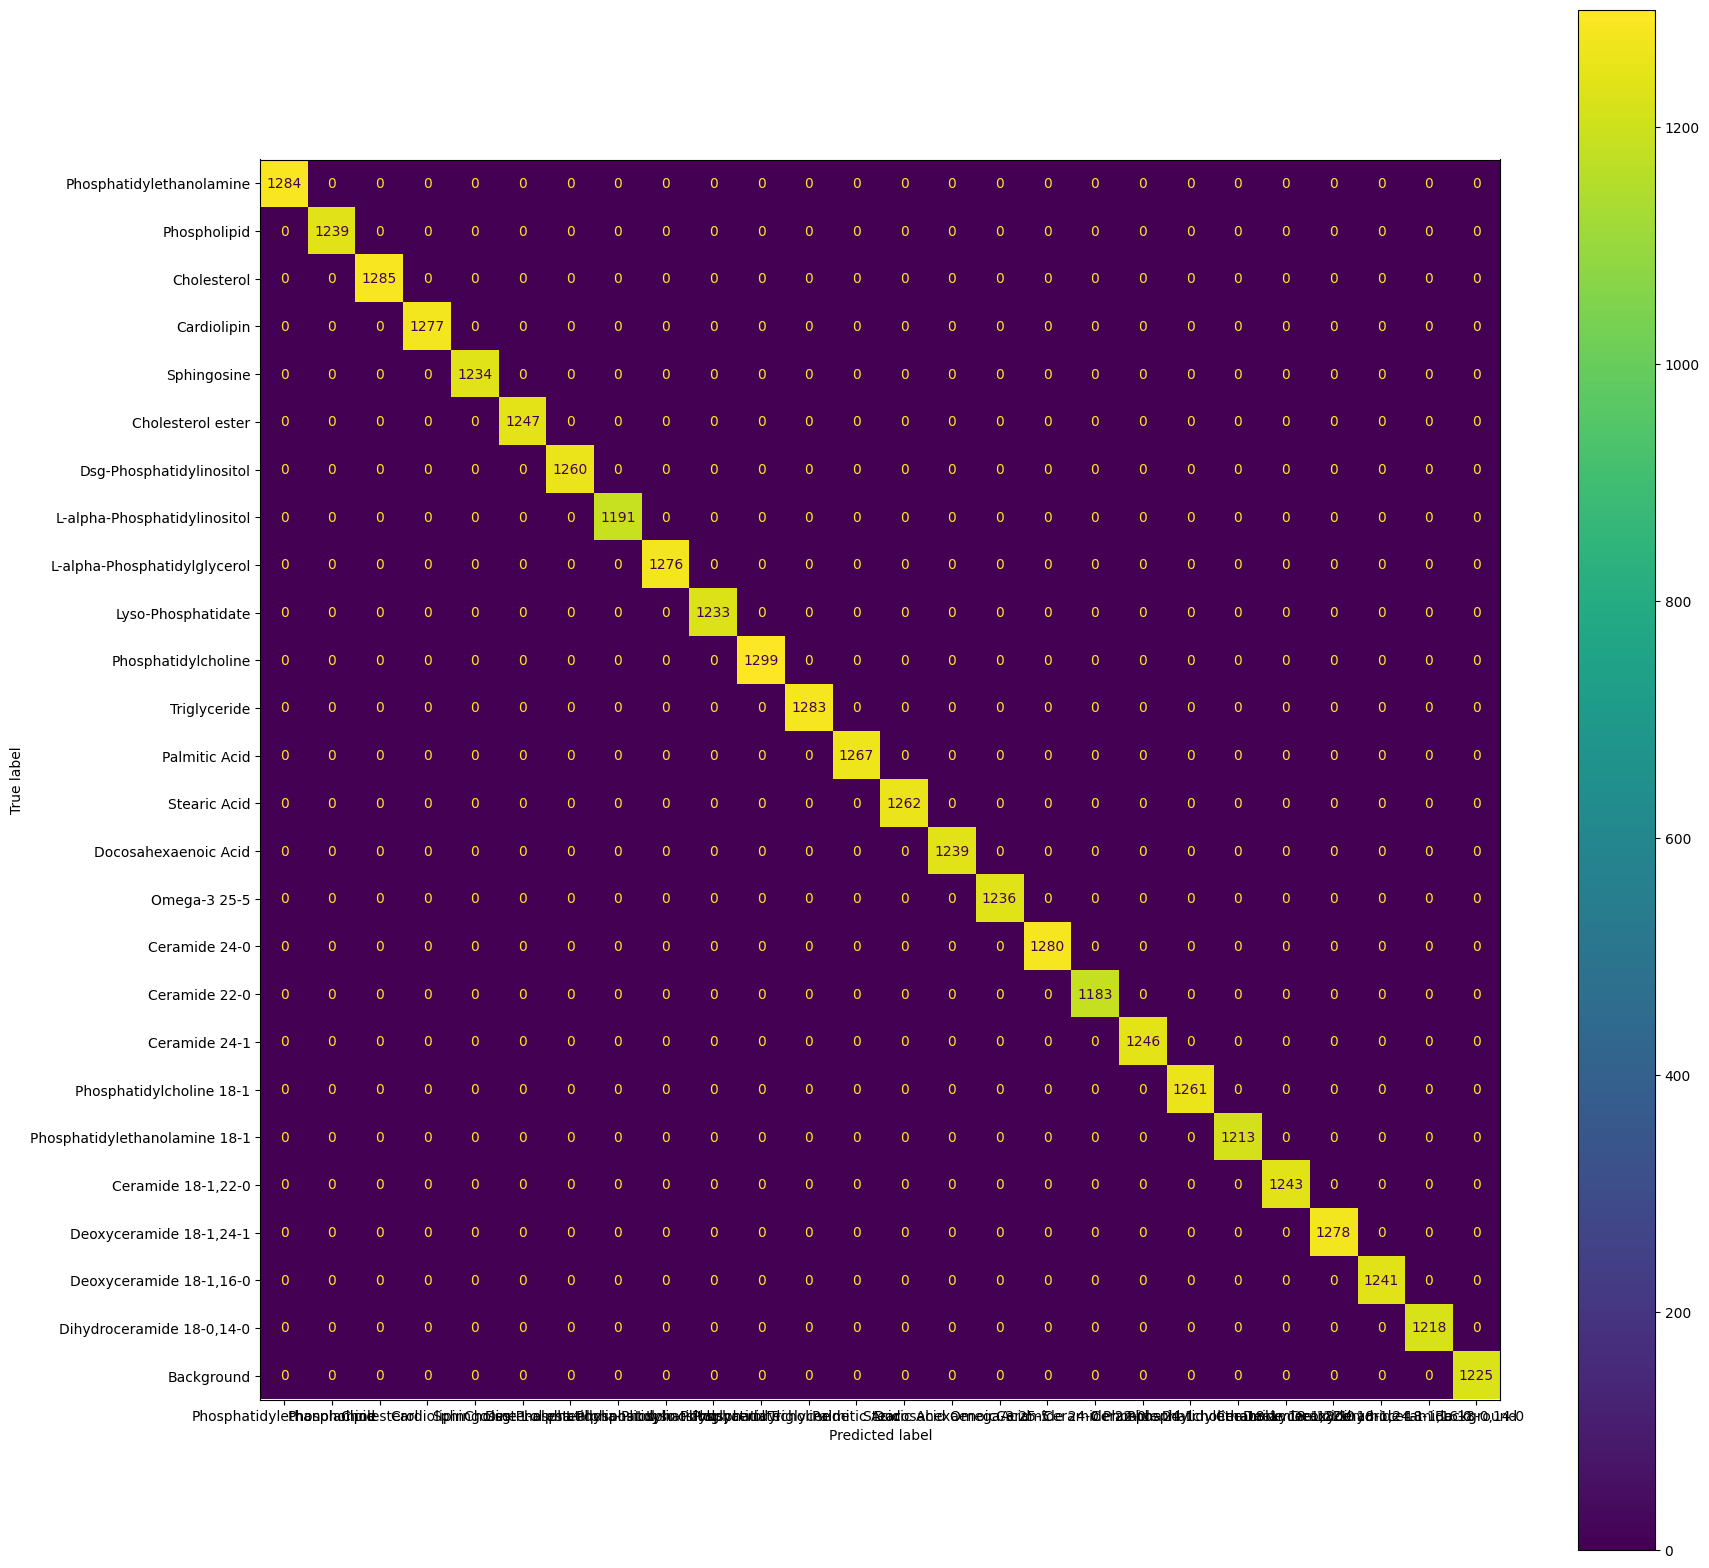

In [17]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [18]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 160.72036242485046 seconds


Save spectral graphs?


 80%|████████  | 20/25 [00:04<00:00,  8.10it/s]d:\Shi_Lab\Spectral_Clustering\ML\unsupervised_scripts.py:418: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))
 64%|██████▍   | 16/25 [00:02<00:01,  5.71it/s]d:\Shi_Lab\Spectral_Clustering\ML\unsupervised_scripts.py:443: UserWarning: D:/Shi_Lab/Spectral_Clustering/ML/output/51wn-3990-HSI.tif/Ceramide 24-0-Probability_Figure.tif is a low contrast image
  io.imsave(save_dir +str(self.label[idx])+'-Probability_Figure.tif', (image*100).astype('float32'))
 68%|██████▊   | 17/25 [00:03<00:01,  4.30it/s]d:\Shi_Lab\Spectral_Clustering\ML\unsupervised_scripts.py:443: UserWarning: D:/Shi_Lab/Spectral_Clustering/ML/output/51wn-3990-HSI.tif/Ceramide 22-0-P

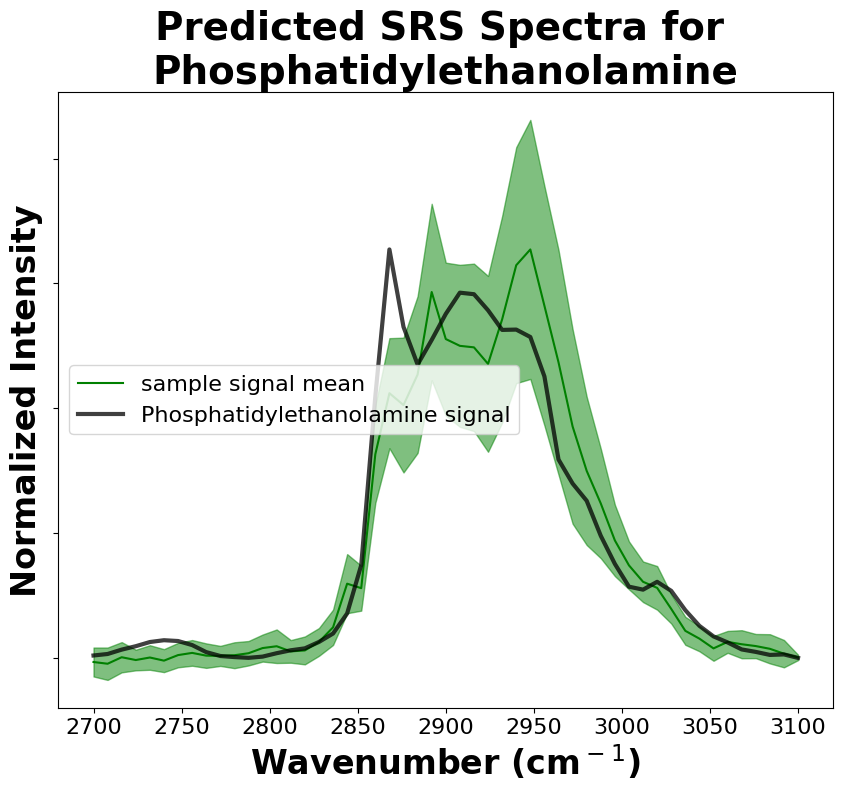

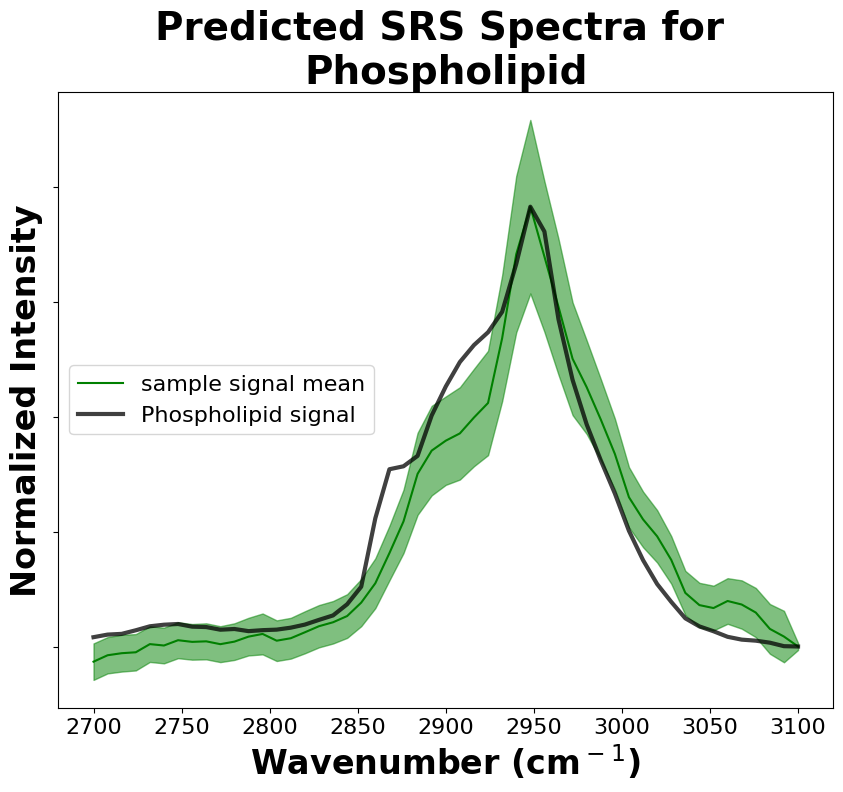

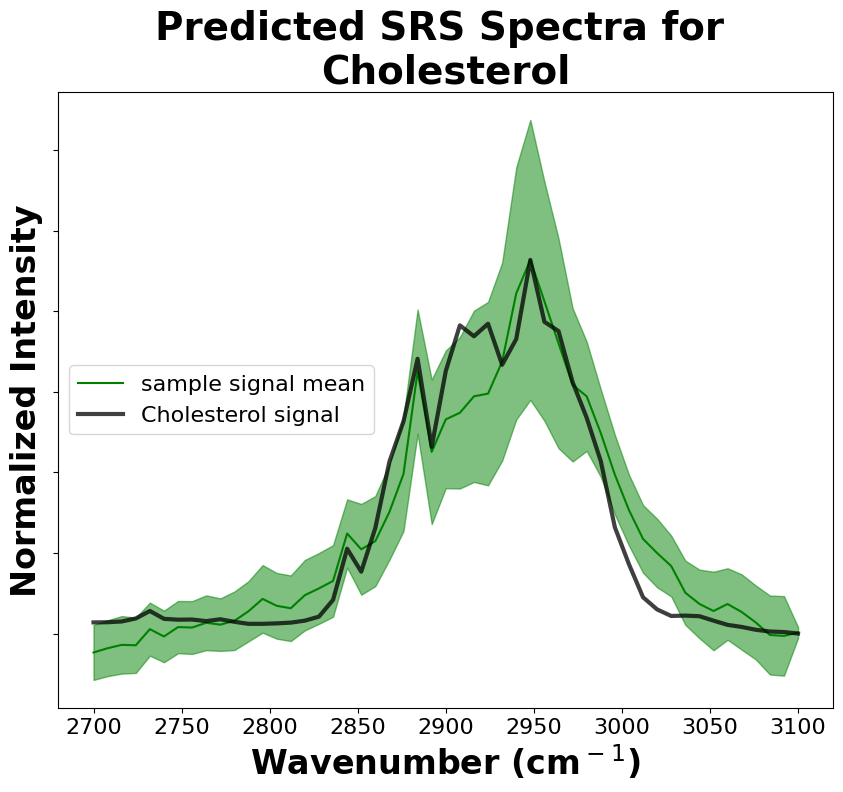

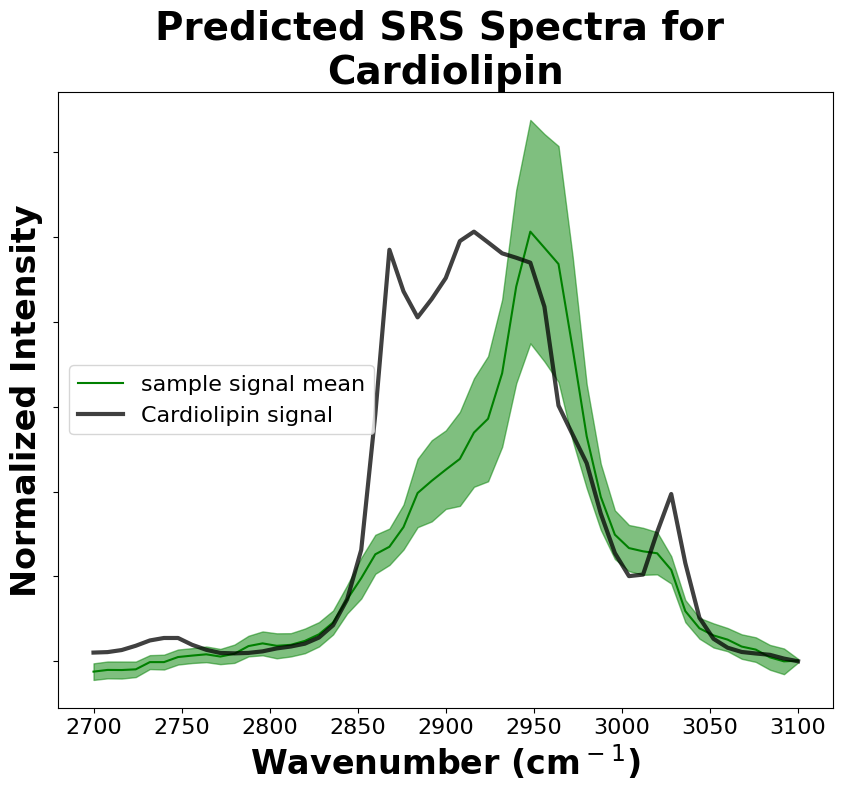

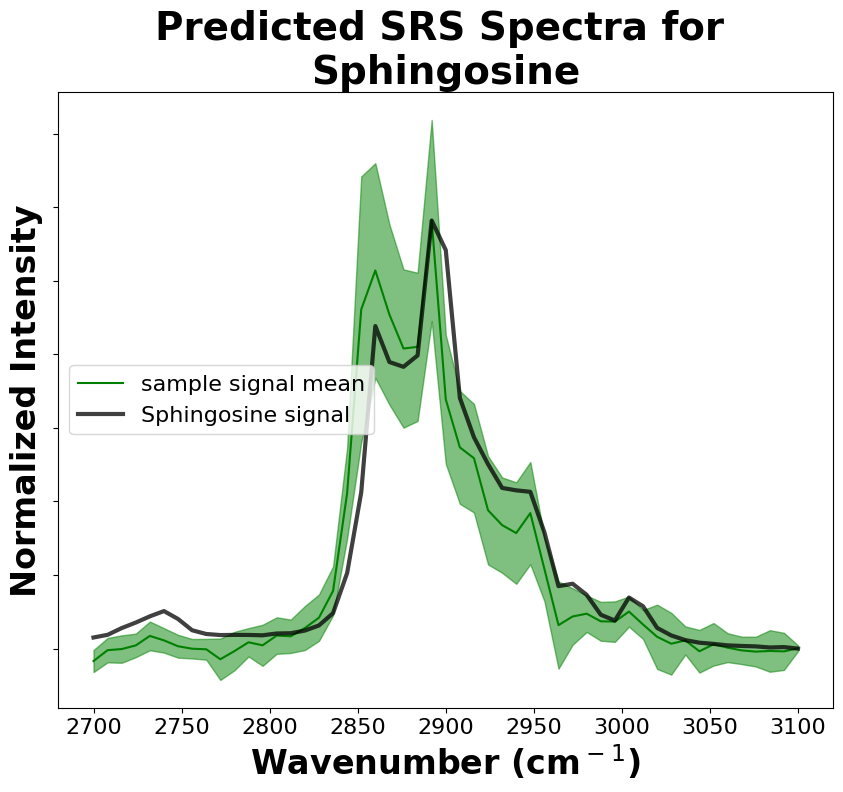

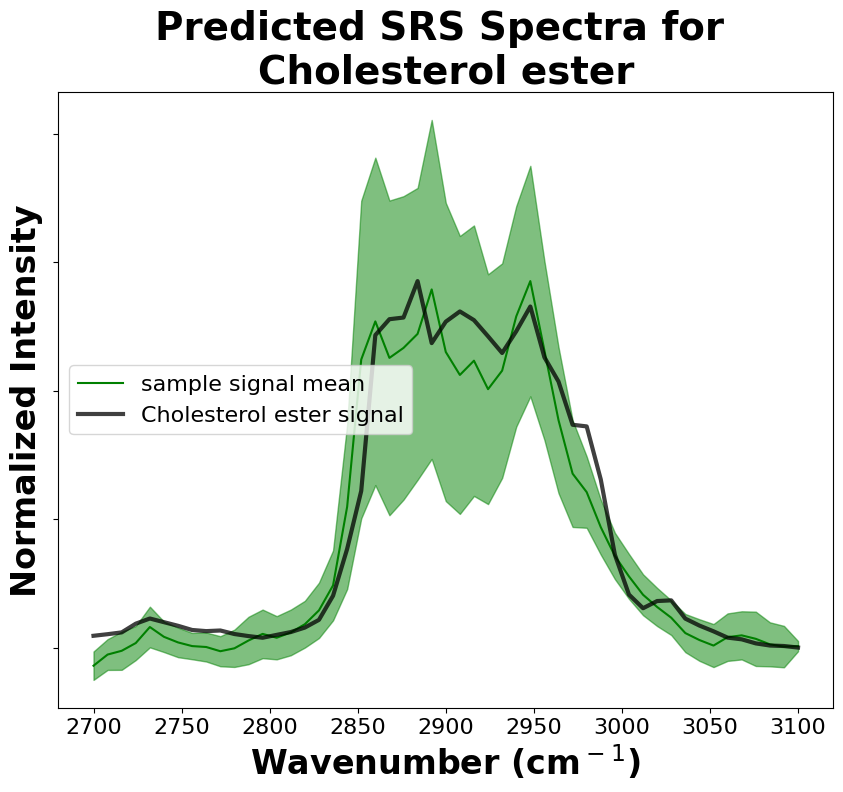

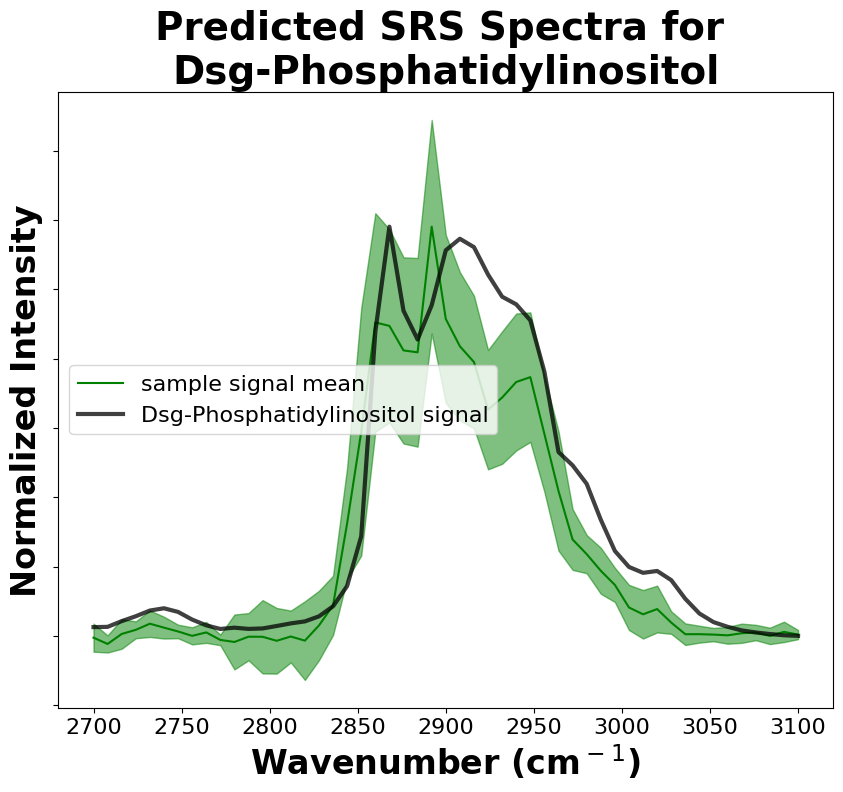

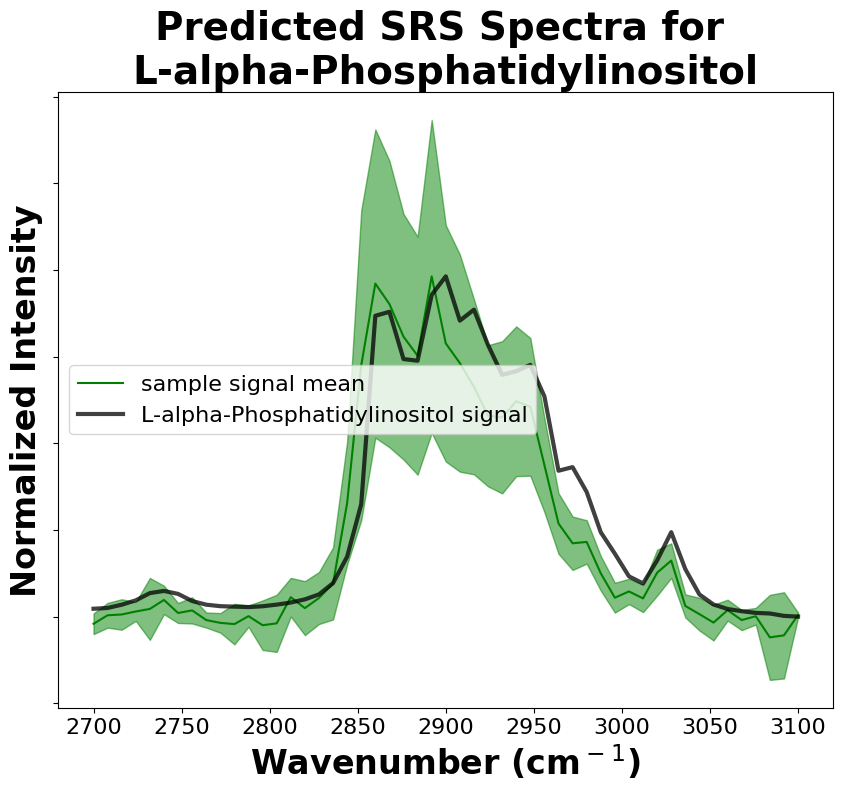

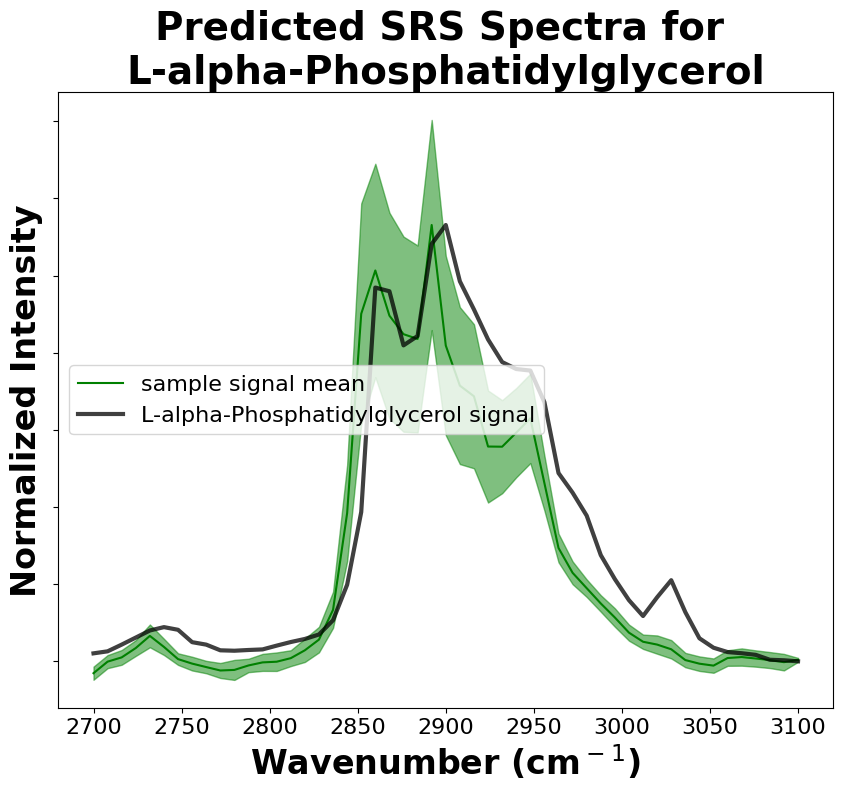

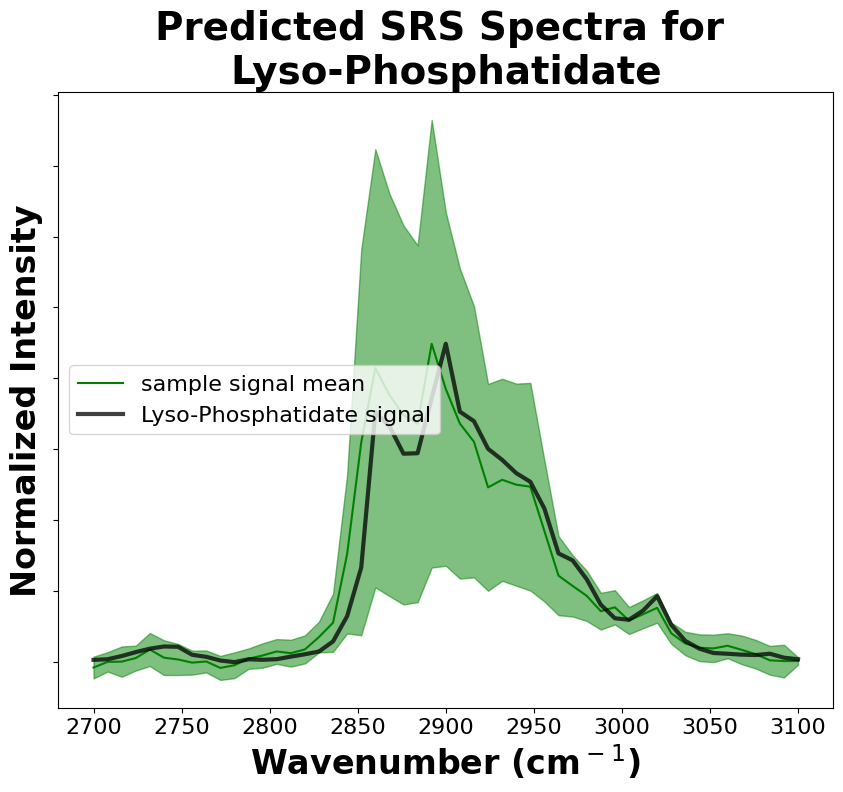

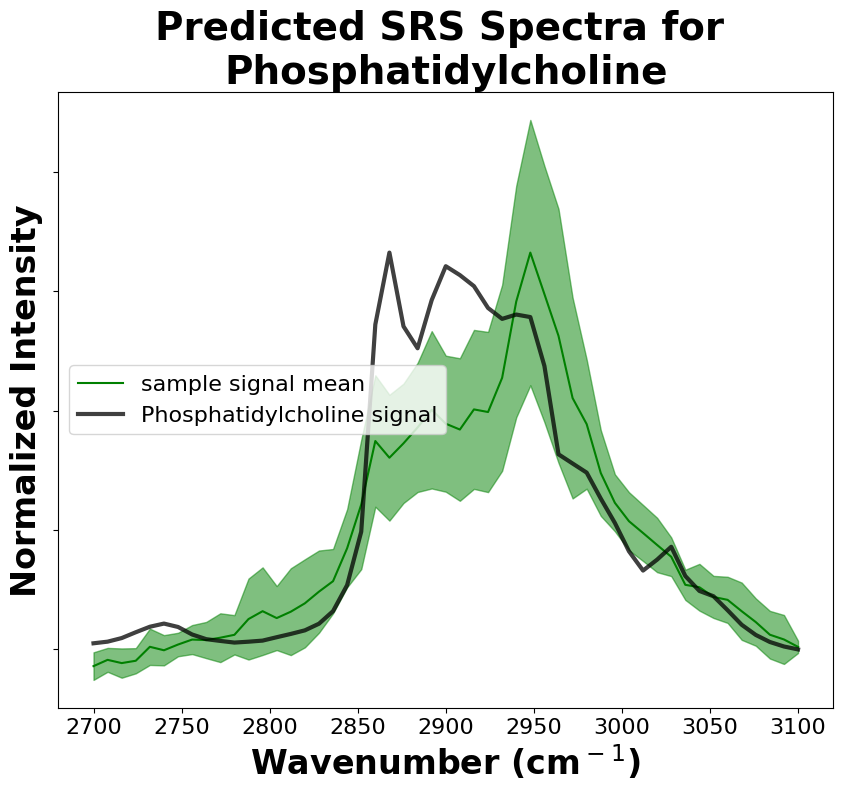

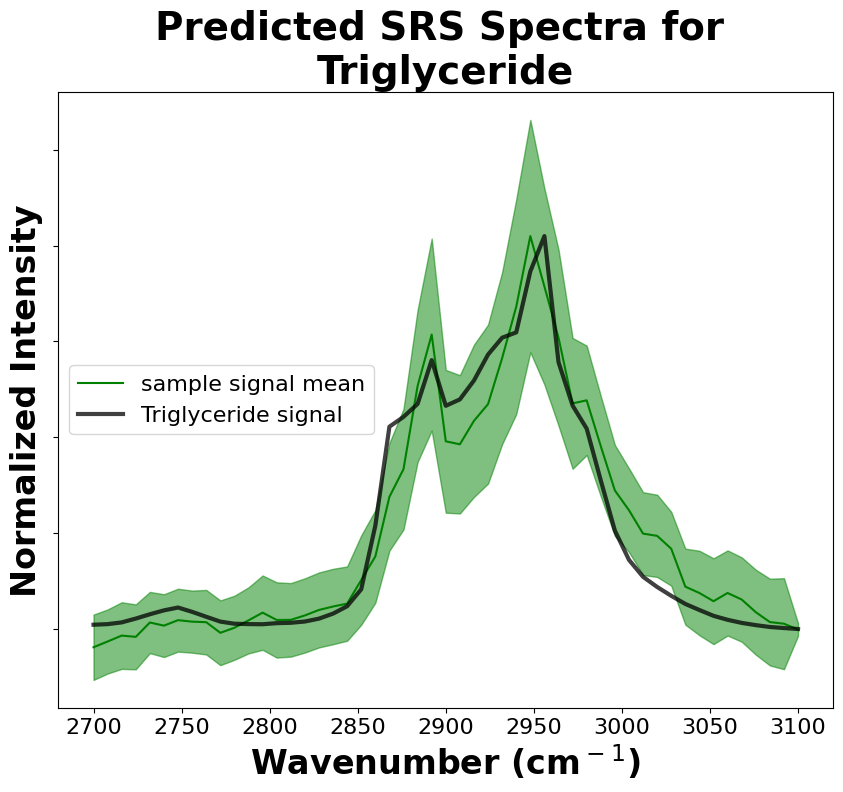

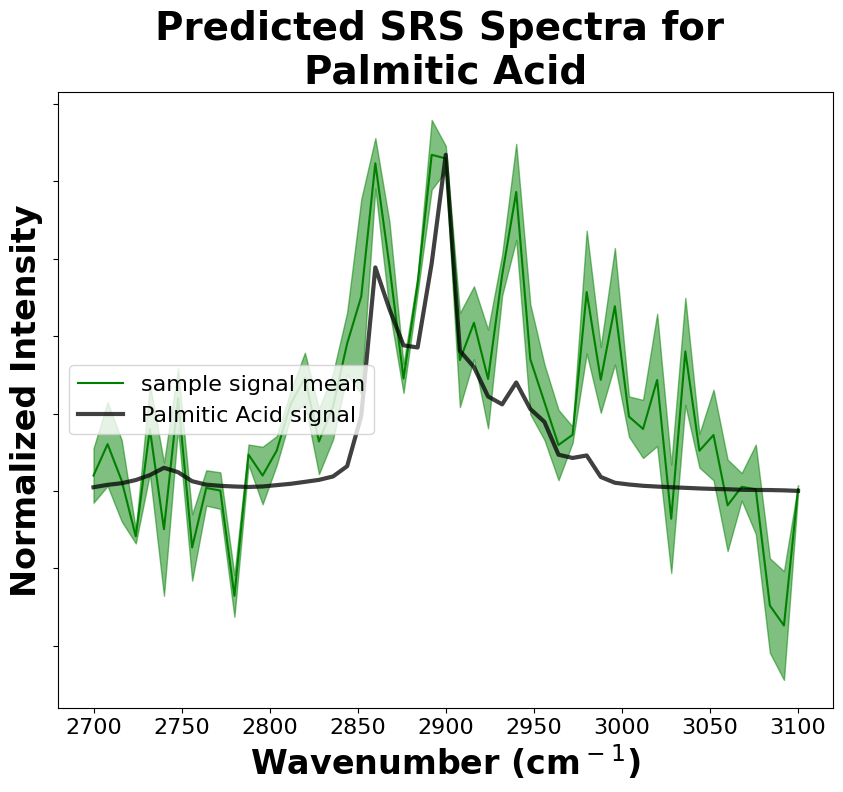

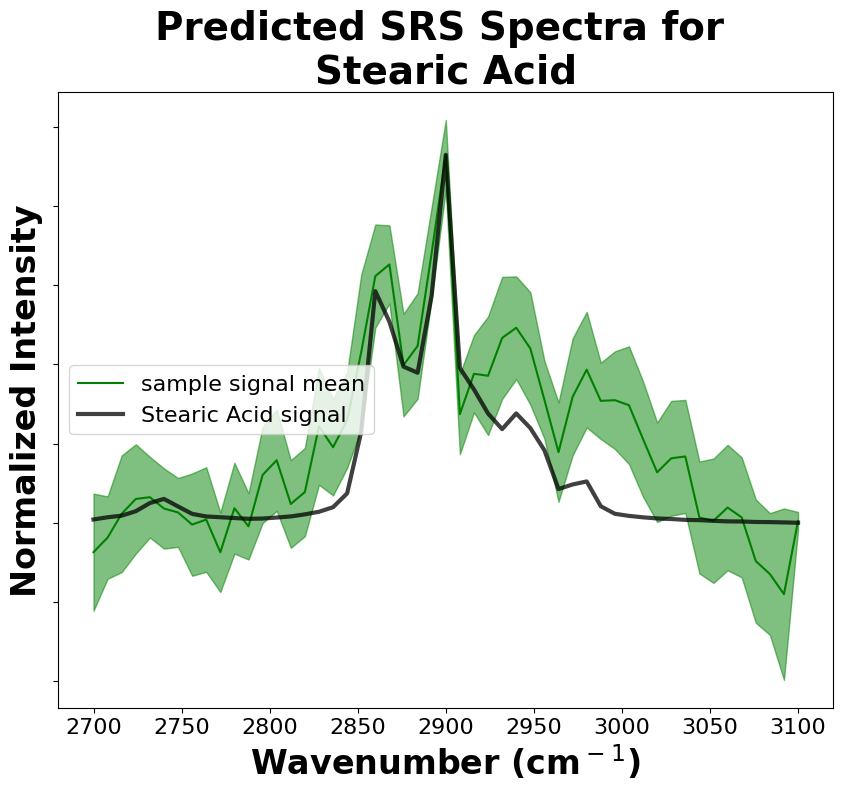

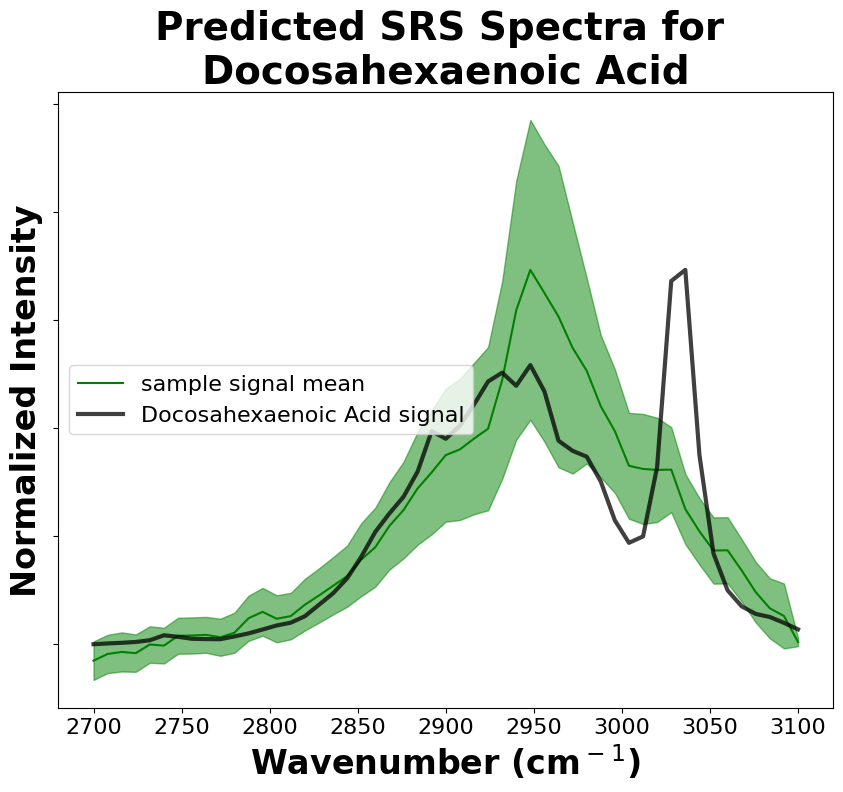

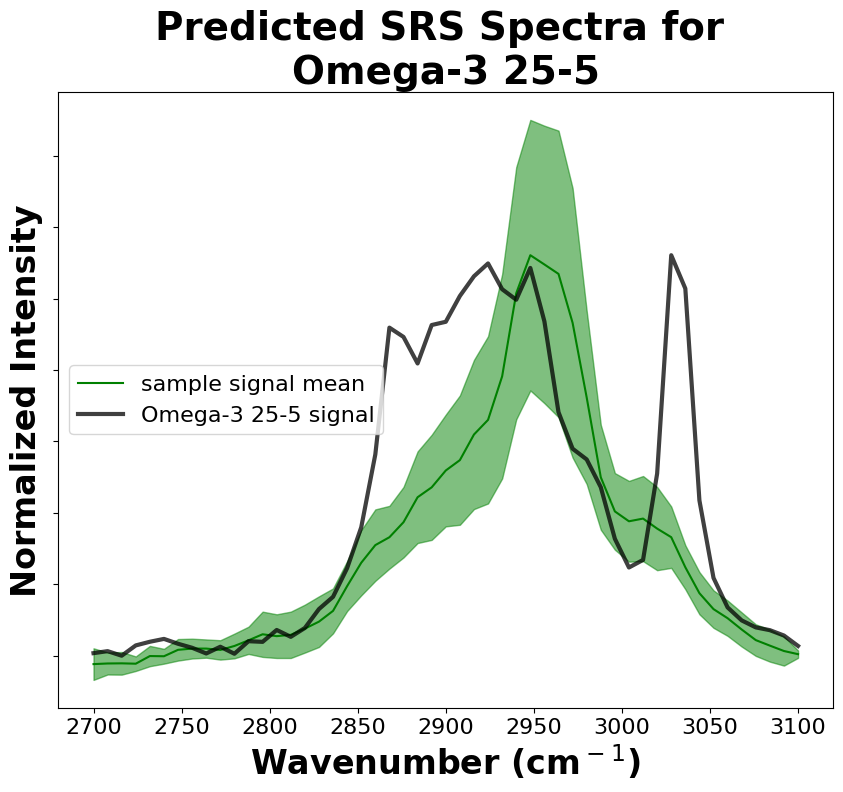

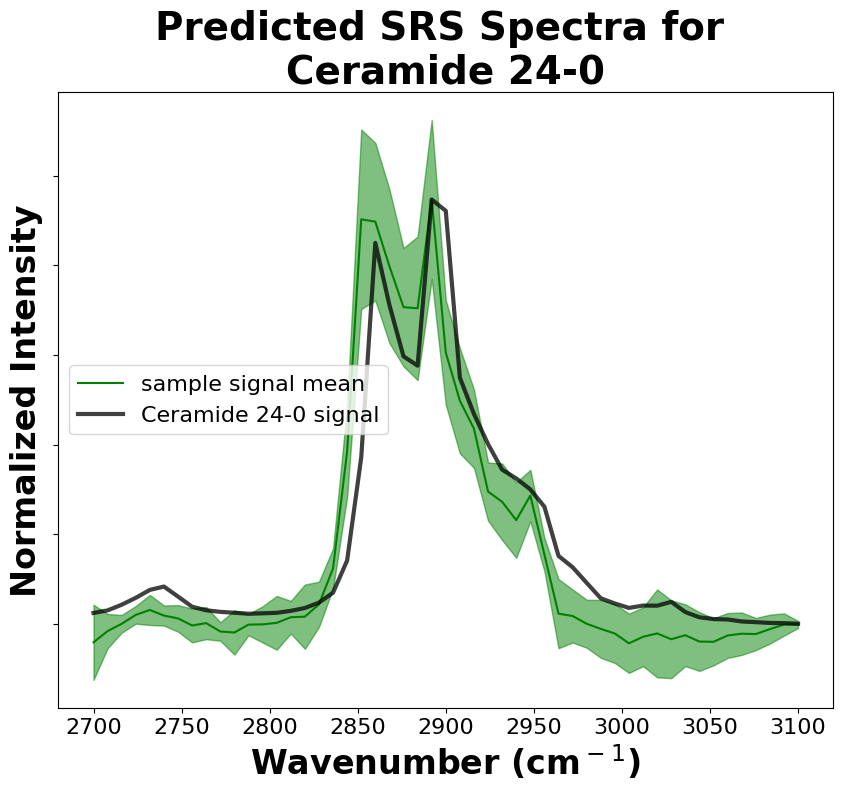

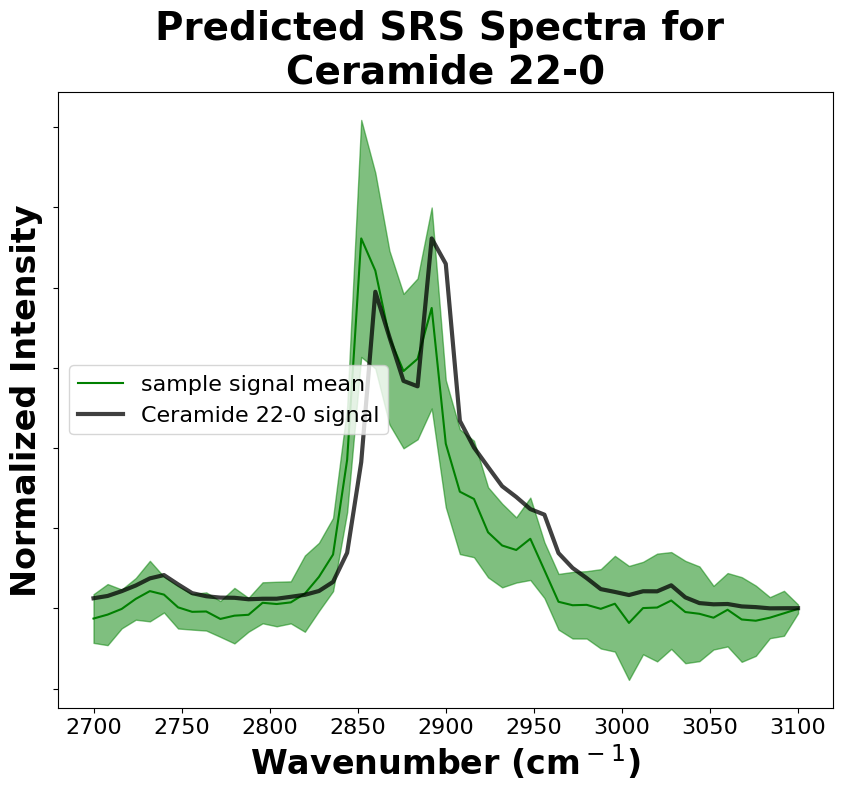

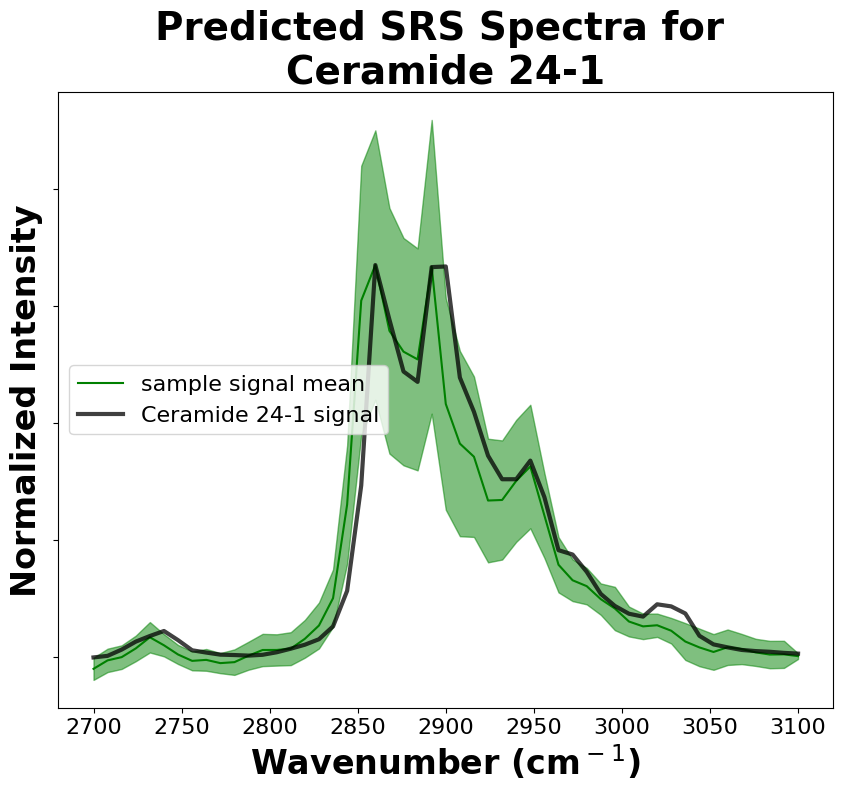

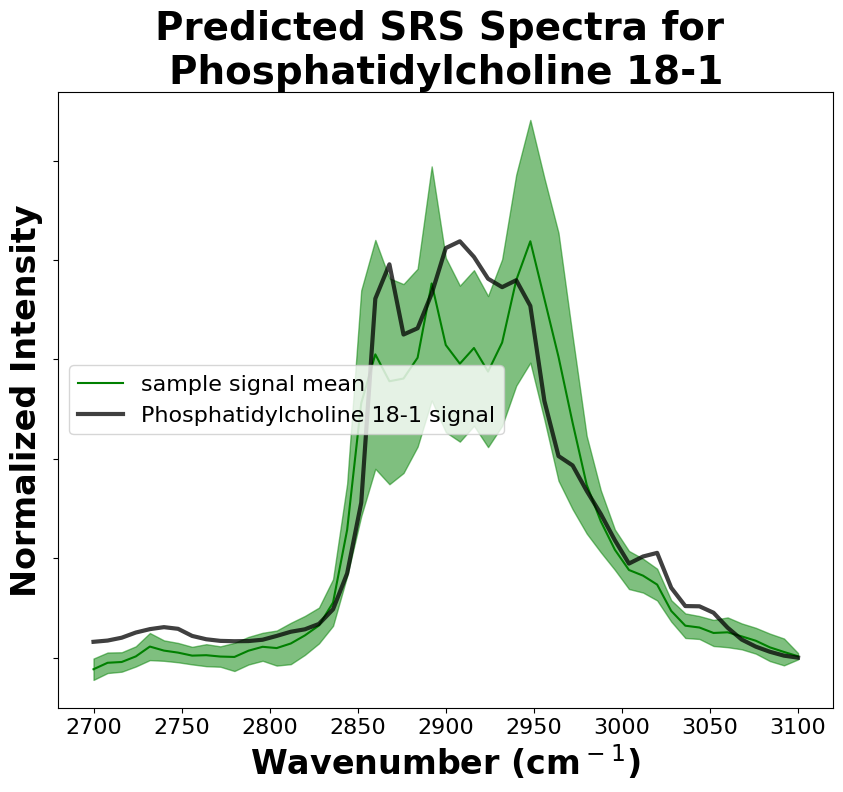

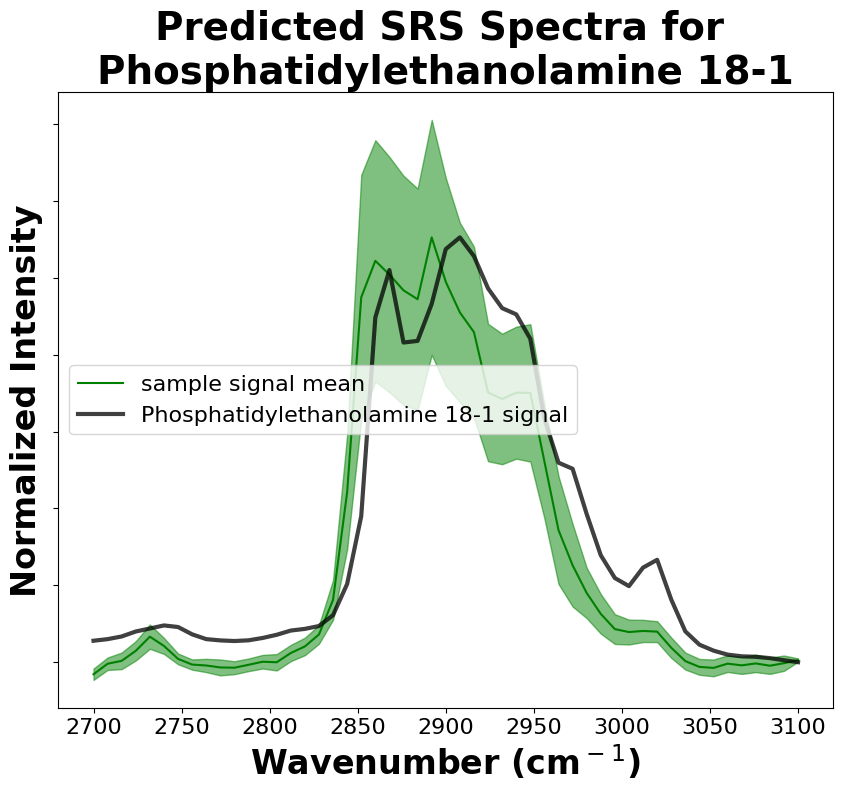

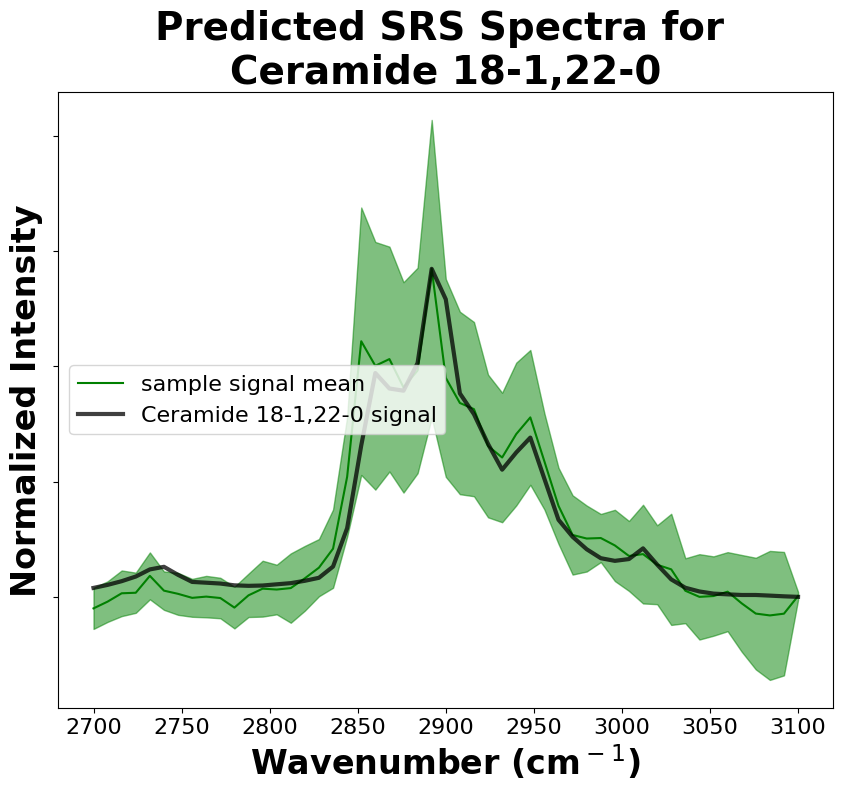

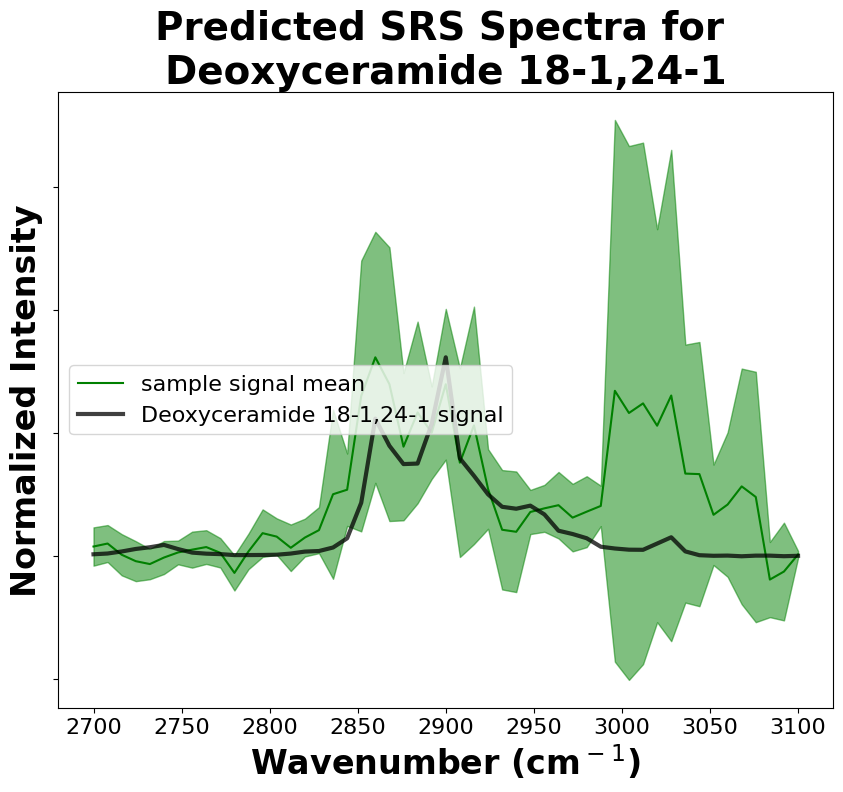

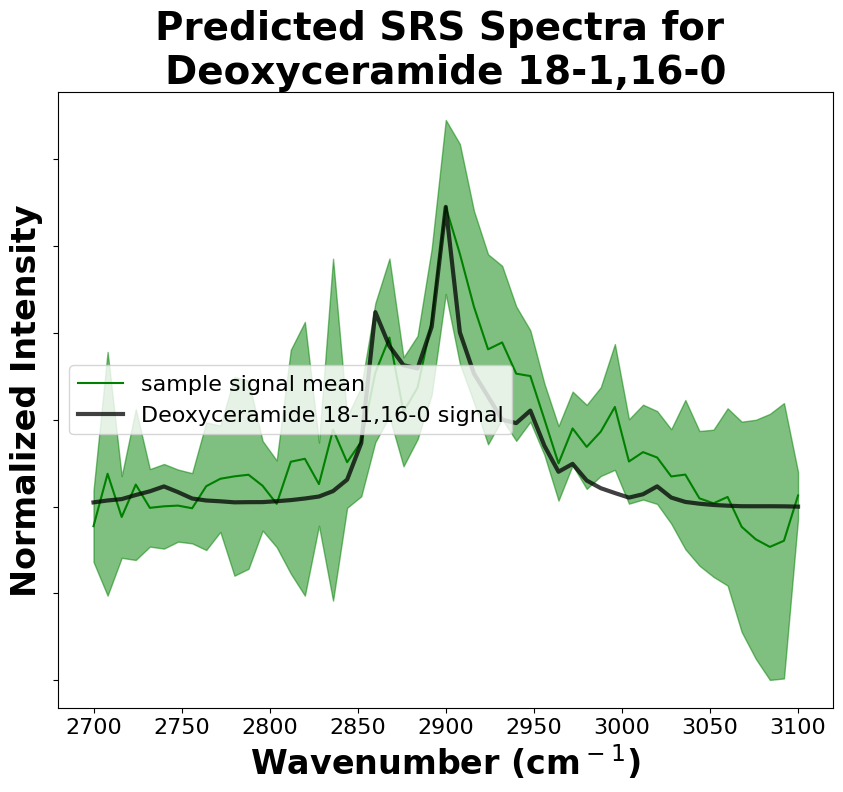

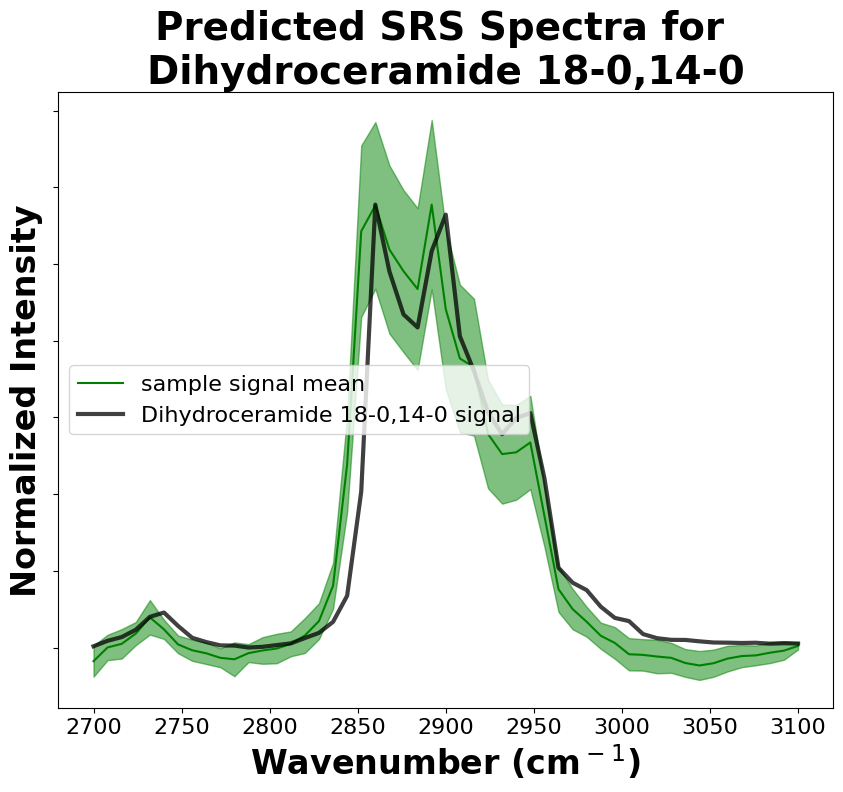

In [10]:
## Spectral Graphs
# save_input = helper_scripts.save_input()
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [19]:
import helper_scripts
print('Save similarity metric .csv?')
ave_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 291/291 [00:00<00:00, 2572.28it/s]


The MSE for Phosphatidylethanolamine is: 0.0030612820214708848
The Cosine Similarity for Phosphatidylethanolamine is: 0.8500230822050642
The Cross-Correlation for Phosphatidylethanolamine is: 0.8535882363816215


100%|██████████| 1469052/1469052 [08:51<00:00, 2761.66it/s]


The MSE for Phospholipid is: 0.005216716525718772
The Cosine Similarity for Phospholipid is: 0.9604031078973368
The Cross-Correlation for Phospholipid is: 0.9604635569132317


100%|██████████| 17116/17116 [00:06<00:00, 2754.01it/s]


The MSE for Cholesterol is: 0.0034999345881287984
The Cosine Similarity for Cholesterol is: 0.9083632644156336
The Cross-Correlation for Cholesterol is: 0.9083632644156335


100%|██████████| 6788/6788 [00:02<00:00, 2787.42it/s]


The MSE for Cardiolipin is: 0.008285970794165553
The Cosine Similarity for Cardiolipin is: 0.9029305236844138
The Cross-Correlation for Cardiolipin is: 0.9111729661183195


100%|██████████| 222/222 [00:00<00:00, 2671.91it/s]


The MSE for Sphingosine is: 0.0025221181079426408
The Cosine Similarity for Sphingosine is: 0.6376979275053146
The Cross-Correlation for Sphingosine is: 0.6376979275053146


100%|██████████| 4921/4921 [00:01<00:00, 2790.02it/s]


The MSE for Cholesterol ester is: 0.011546872801211045
The Cosine Similarity for Cholesterol ester is: 0.8430854449448266
The Cross-Correlation for Cholesterol ester is: 0.8430854449448265


100%|██████████| 105/105 [00:00<00:00, 2587.13it/s]


The MSE for Dsg-Phosphatidylinositol is: 0.006381363531643937
The Cosine Similarity for Dsg-Phosphatidylinositol is: 0.9542261269662233
The Cross-Correlation for Dsg-Phosphatidylinositol is: 0.9592514675118341


100%|██████████| 52/52 [00:00<00:00, 1868.69it/s]


The MSE for L-alpha-Phosphatidylinositol is: 0.1425231287344276
The Cosine Similarity for L-alpha-Phosphatidylinositol is: 0.9336898664694886
The Cross-Correlation for L-alpha-Phosphatidylinositol is: 0.9588127052104476


100%|██████████| 152/152 [00:00<00:00, 2686.96it/s]


The MSE for L-alpha-Phosphatidylglycerol is: 0.00911080244507609
The Cosine Similarity for L-alpha-Phosphatidylglycerol is: 0.965200810226956
The Cross-Correlation for L-alpha-Phosphatidylglycerol is: 0.9652008102269563


100%|██████████| 808/808 [00:00<00:00, 2837.40it/s]


The MSE for Lyso-Phosphatidate is: 0.004047218440179387
The Cosine Similarity for Lyso-Phosphatidate is: 0.6542906964505275
The Cross-Correlation for Lyso-Phosphatidate is: 0.6626804695379855


100%|██████████| 1273/1273 [00:00<00:00, 2762.41it/s]


The MSE for Phosphatidylcholine is: 0.004827797909373855
The Cosine Similarity for Phosphatidylcholine is: 0.9201532824348639
The Cross-Correlation for Phosphatidylcholine is: 0.9201532824348638


100%|██████████| 39712/39712 [00:14<00:00, 2767.83it/s]


The MSE for Triglyceride is: 0.004529513549496133
The Cosine Similarity for Triglyceride is: 0.667902881809153
The Cross-Correlation for Triglyceride is: 0.6875970725512088


100%|██████████| 36/36 [00:00<00:00, 1936.50it/s]


The MSE for Palmitic Acid is: 0.002288831794824455
The Cosine Similarity for Palmitic Acid is: 0.5757751181987723
The Cross-Correlation for Palmitic Acid is: 0.5757751181987724


100%|██████████| 32/32 [00:00<00:00, 1514.70it/s]


The MSE for Stearic Acid is: 0.002325894439979722
The Cosine Similarity for Stearic Acid is: 0.6927806852568796
The Cross-Correlation for Stearic Acid is: 0.7282700347365934


100%|██████████| 127945/127945 [00:46<00:00, 2762.69it/s]


The MSE for Docosahexaenoic Acid is: 0.011164698383213194
The Cosine Similarity for Docosahexaenoic Acid is: 0.5489114825836431
The Cross-Correlation for Docosahexaenoic Acid is: 0.6954696409982178


100%|██████████| 1996/1996 [00:00<00:00, 2784.44it/s]


The MSE for Omega-3 25-5 is: 0.005645493102699231
The Cosine Similarity for Omega-3 25-5 is: 0.9001856514861293
The Cross-Correlation for Omega-3 25-5 is: 0.9033433666644277


100%|██████████| 46/46 [00:00<00:00, 1361.84it/s]


The MSE for Ceramide 24-0 is: 0.1405827610421758
The Cosine Similarity for Ceramide 24-0 is: 0.9268672634536905
The Cross-Correlation for Ceramide 24-0 is: 0.9658627431265644


100%|██████████| 148/148 [00:00<00:00, 3066.74it/s]


The MSE for Ceramide 22-0 is: 0.013589211745887219
The Cosine Similarity for Ceramide 22-0 is: 0.43322161967878214
The Cross-Correlation for Ceramide 22-0 is: 0.5912373618899931


100%|██████████| 710/710 [00:00<00:00, 2602.10it/s]


The MSE for Ceramide 24-1 is: 0.01881067982946708
The Cosine Similarity for Ceramide 24-1 is: 0.9333485338787495
The Cross-Correlation for Ceramide 24-1 is: 0.9564586219867465


100%|██████████| 986/986 [00:00<00:00, 2775.60it/s]


The MSE for Phosphatidylcholine 18-1 is: 0.007042918829492112
The Cosine Similarity for Phosphatidylcholine 18-1 is: 0.9187958829541395
The Cross-Correlation for Phosphatidylcholine 18-1 is: 0.9187958829541395


100%|██████████| 404/404 [00:00<00:00, 2660.75it/s]


The MSE for Phosphatidylethanolamine 18-1 is: 0.006746869680739678
The Cosine Similarity for Phosphatidylethanolamine 18-1 is: 0.8851741312672159
The Cross-Correlation for Phosphatidylethanolamine 18-1 is: 0.9212182068190186


100%|██████████| 1771/1771 [00:00<00:00, 2829.00it/s]


The MSE for Ceramide 18-1,22-0 is: 0.0015835736915030324
The Cosine Similarity for Ceramide 18-1,22-0 is: 0.7868626381848502
The Cross-Correlation for Ceramide 18-1,22-0 is: 0.7868626381848502


100%|██████████| 148/148 [00:00<00:00, 2218.72it/s]


The MSE for Deoxyceramide 18-1,24-1 is: 0.003048340236080508
The Cosine Similarity for Deoxyceramide 18-1,24-1 is: 0.5247614375299845
The Cross-Correlation for Deoxyceramide 18-1,24-1 is: 0.5374416124135657


100%|██████████| 649/649 [00:00<00:00, 2838.13it/s]


The MSE for Deoxyceramide 18-1,16-0 is: 0.0028433738313315532
The Cosine Similarity for Deoxyceramide 18-1,16-0 is: 0.6788714255008407
The Cross-Correlation for Deoxyceramide 18-1,16-0 is: 0.7099091941088852


100%|██████████| 375/375 [00:00<00:00, 2503.30it/s]


The MSE for Dihydroceramide 18-0,14-0 is: 0.040894145429025246
The Cosine Similarity for Dihydroceramide 18-0,14-0 is: 0.7647616898428662
The Cross-Correlation for Dihydroceramide 18-0,14-0 is: 0.7969382835677117
